In [ ]:
!pip install numpy pandas matplotlib scikit-learn tensorflow


Cox-Stuart Trend Test:

A non-parametric test to check if there is a significant upward or downward trend in the data.
It splits the time series into two halves and checks if values in the second half are generally larger than those in the first half.
A p-value is calculated to assess the trend significance.
LSTM Predictions:

Predict future values for the next 10 years using an LSTM model.
Evaluate the model using MSE and MAPE and plot future predictions with 95% confidence intervals.
Displaying Results:

The p-value from the Cox-Stuart test is displayed, and the plot includes both the predicted values and the confidence intervals, with annotations showing MSE and MAPE values.
Expected Outputs:
Cox-Stuart Test Result: Indicates if there's a statistically significant trend in the historical data.
Plot: Shows the historical publication data, future predictions for 10 years, and 95% confidence intervals.
MSE and MAPE: Metrics displayed both in the output and on the plot.

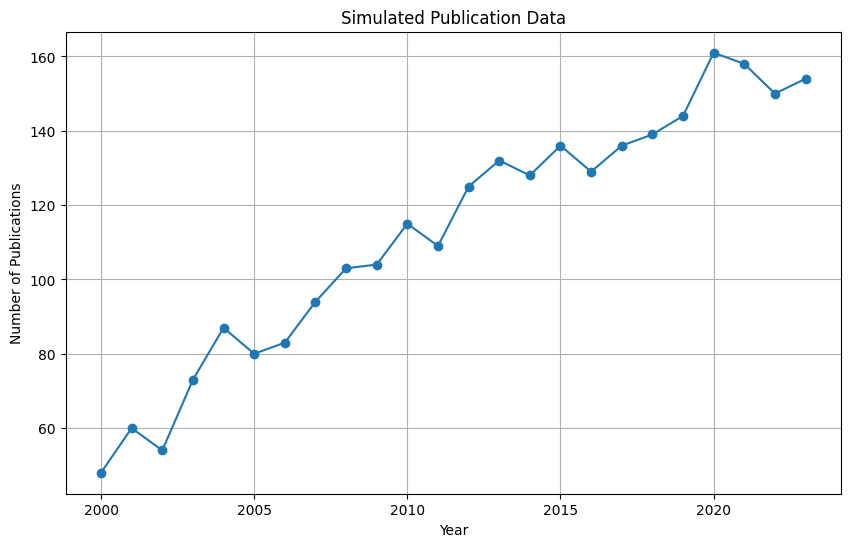

Cox-Stuart Trend Test p-value: 0.0005
There is a significant trend in the data.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Mean Squared Error on Test Data: 188.69281269847414
Mean Absolute Percentage Error on Test Data: 0.07062094726459617


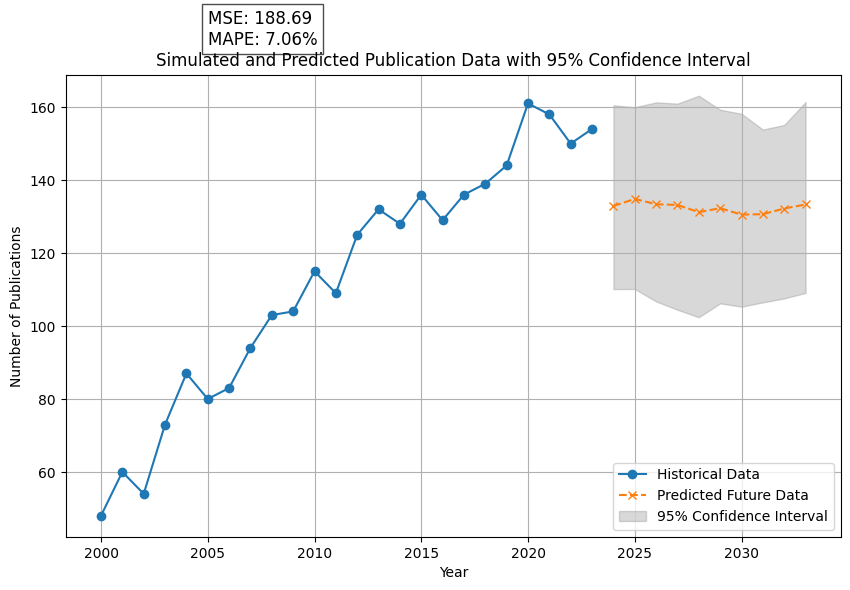

Predicted publications for 2024: 132.88 (95% CI: [110.12, 160.50])
Predicted publications for 2025: 134.84 (95% CI: [110.15, 159.95])
Predicted publications for 2026: 133.37 (95% CI: [106.73, 161.30])
Predicted publications for 2027: 133.18 (95% CI: [104.46, 160.95])
Predicted publications for 2028: 131.21 (95% CI: [102.39, 163.12])
Predicted publications for 2029: 132.30 (95% CI: [106.20, 159.29])
Predicted publications for 2030: 130.53 (95% CI: [105.30, 158.18])
Predicted publications for 2031: 130.65 (95% CI: [106.46, 153.85])
Predicted publications for 2032: 132.21 (95% CI: [107.57, 155.11])
Predicted publications for 2033: 133.31 (95% CI: [109.07, 161.39])


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from scipy import stats

# Function for the Cox and Stuart trend test
def cox_stuart_test(data):
    """
    Perform the Cox and Stuart trend test for a time series.
    Returns the p-value of the test.
    """
    n = len(data)
    half_n = n // 2

    # Split the data into the first and second halves
    first_half = data[:half_n]
    second_half = data[-half_n:]

    # Compare the two halves
    comparisons = second_half - first_half

    # Count how many values in the second half are larger than the first half
    positives = np.sum(comparisons > 0)
    negatives = np.sum(comparisons < 0)

    # Perform binomial test to check if there's a significant trend
    p_value = stats.binomtest(positives, positives + negatives, alternative='two-sided').pvalue
    return p_value

# Generate example time series data: Let's simulate yearly publication data
np.random.seed(42)
years = np.arange(2000, 2024)
publications = np.random.poisson(lam=50, size=len(years)) + np.cumsum(np.random.randint(0, 10, size=len(years)))

# Creating a DataFrame for visualization
data = pd.DataFrame({'Year': years, 'Publications': publications})

# Plotting the example data
plt.figure(figsize=(10, 6))
plt.plot(data['Year'], data['Publications'], marker='o')
plt.title('Simulated Publication Data')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.grid(True)
plt.show()

# Applying Cox and Stuart Trend Test
p_value = cox_stuart_test(data['Publications'].values)
print(f'Cox-Stuart Trend Test p-value: {p_value:.4f}')

if p_value < 0.05:
    print("There is a significant trend in the data.")
else:
    print("There is no significant trend in the data.")

# Preparing the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Publications']])

# Creating sequences (we will use the past 3 years to predict the next year)
def create_sequences(data, time_steps=3):
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:i+time_steps, 0])
        y.append(data[i+time_steps, 0])
    return np.array(x), np.array(y)

time_steps = 3
X, y = create_sequences(scaled_data, time_steps)

# Train-test split (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model (suppress verbose output)
model.fit(X_train, y_train, epochs=100, verbose=0)

# Predicting on the test set (suppress verbose output)
y_pred_scaled = model.predict(X_test, verbose=0)
y_pred = scaler.inverse_transform(y_pred_scaled)

# Evaluate the model using Mean Squared Error (MSE) and Mean Absolute Percentage Error (MAPE)
mse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred)
mape = mean_absolute_percentage_error(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred)
print(f'Mean Squared Error on Test Data: {mse}')
print(f'Mean Absolute Percentage Error on Test Data: {mape}')

# Predict the next 10 years of publications with confidence intervals
future_predictions = []
conf_intervals = []
num_simulations = 100  # Number of simulations to estimate confidence intervals

for i in range(10):
    simulated_preds = []
    last_sequence = scaled_data[-time_steps:]

    # Simulate predictions by adding some noise to each prediction
    for _ in range(num_simulations):
        # Reshape last_sequence for prediction
        last_sequence = last_sequence.reshape((1, time_steps, 1))

        # Predict the next value (suppress verbose output)
        next_pred_scaled = model.predict(last_sequence, verbose=0)
        next_pred = scaler.inverse_transform(next_pred_scaled)

        # Adding small noise for simulation
        simulated_preds.append(next_pred[0][0] + np.random.normal(0, 0.1 * next_pred[0][0]))

        # Update the last_sequence with the new predicted value
        last_sequence = np.append(last_sequence[0][1:], next_pred_scaled).reshape((time_steps, 1))

    # Calculate mean and confidence interval (95%)
    mean_pred = np.mean(simulated_preds)
    lower_bound = np.percentile(simulated_preds, 2.5)
    upper_bound = np.percentile(simulated_preds, 97.5)

    future_predictions.append(mean_pred)
    conf_intervals.append((lower_bound, upper_bound))

# Plot the future predictions with confidence intervals and display MSE and MAPE in the plot
future_years = np.arange(2024, 2024+10)
plt.figure(figsize=(10, 6))
plt.plot(data['Year'], data['Publications'], marker='o', label='Historical Data')
plt.plot(future_years, future_predictions, marker='x', linestyle='--', label='Predicted Future Data')

# Adding the confidence intervals
lower_bounds = [ci[0] for ci in conf_intervals]
upper_bounds = [ci[1] for ci in conf_intervals]
plt.fill_between(future_years, lower_bounds, upper_bounds, color='gray', alpha=0.3, label='95% Confidence Interval')

# Annotate the plot with MSE and MAPE
plt.text(2005, max(publications) * 1.1, f'MSE: {mse:.2f}\nMAPE: {mape:.2%}', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

plt.title('Simulated and Predicted Publication Data with 95% Confidence Interval')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print future predictions with confidence intervals
for year, prediction, ci in zip(future_years, future_predictions, conf_intervals):
    print(f"Predicted publications for {year}: {prediction:.2f} (95% CI: [{ci[0]:.2f}, {ci[1]:.2f}])")


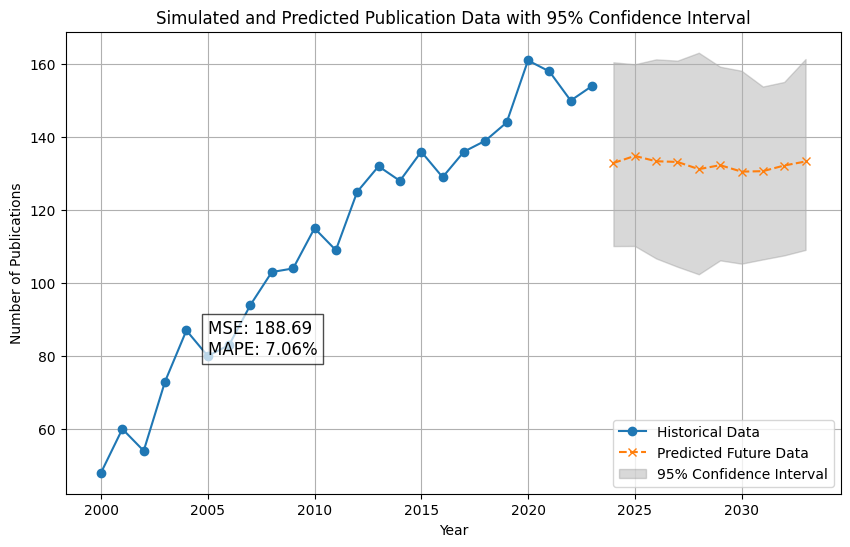

Predicted publications for 2024: 132.88 (95% CI: [110.12, 160.50])
Predicted publications for 2025: 134.84 (95% CI: [110.15, 159.95])
Predicted publications for 2026: 133.37 (95% CI: [106.73, 161.30])
Predicted publications for 2027: 133.18 (95% CI: [104.46, 160.95])
Predicted publications for 2028: 131.21 (95% CI: [102.39, 163.12])
Predicted publications for 2029: 132.30 (95% CI: [106.20, 159.29])
Predicted publications for 2030: 130.53 (95% CI: [105.30, 158.18])
Predicted publications for 2031: 130.65 (95% CI: [106.46, 153.85])
Predicted publications for 2032: 132.21 (95% CI: [107.57, 155.11])
Predicted publications for 2033: 133.31 (95% CI: [109.07, 161.39])


In [49]:
# Plot the future predictions with confidence intervals and display MSE and MAPE in the plot
future_years = np.arange(2024, 2024+10)
plt.figure(figsize=(10, 6))
plt.plot(data['Year'], data['Publications'], marker='o', label='Historical Data')
plt.plot(future_years, future_predictions, marker='x', linestyle='--', label='Predicted Future Data')

# Adding the confidence intervals
lower_bounds = [ci[0] for ci in conf_intervals]
upper_bounds = [ci[1] for ci in conf_intervals]
plt.fill_between(future_years, lower_bounds, upper_bounds, color='gray', alpha=0.3, label='95% Confidence Interval')

# Annotate the plot with MSE and MAPE
plt.text(2005, max(publications) * 0.5, f'MSE: {mse:.2f}\nMAPE: {mape:.2%}', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.title('Simulated and Predicted Publication Data with 95% Confidence Interval')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print future predictions with confidence intervals
for year, prediction, ci in zip(future_years, future_predictions, conf_intervals):
    print(f"Predicted publications for {year}: {prediction:.2f} (95% CI: [{ci[0]:.2f}, {ci[1]:.2f}])")


In [ ]:
data

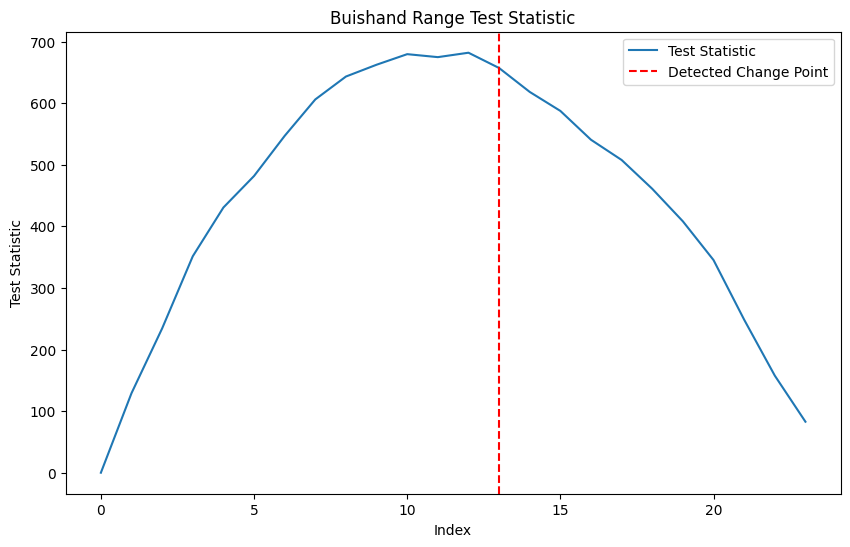

Detected change point at index: 13


In [50]:
import numpy as np
import matplotlib.pyplot as plt
# The Buishand Range Test is a statistical test used for detecting change points in time series data.
# This test checks for changes in the mean of a time series and is particularly useful for identifying structural breaks.
def buishand_range_test(x):
    """
    Buishand Range Test for change-point detection in time series data.

    Parameters:
    x (list or np.array): The time series data.

    Returns:
    change_point_index (int): The index of the detected change point.
    """
    n = len(x)
    if n < 2:
        raise ValueError("Time series data must contain at least two observations.")

    # Compute cumulative sum of the time series
    S = np.cumsum(x - np.mean(x))
    S = np.insert(S, 0, 0)  # Add zero at the beginning for ease of computation

    # Compute range statistics
    R = np.max(S) - np.min(S)

    # Calculate the test statistic for each possible change point
    test_statistic = np.zeros(n)
    for k in range(1, n):
        S1 = S[k]
        S2 = S[-1] - S[k]
        test_statistic[k] = np.abs(S1 - S2)

    # Find the index of the maximum test statistic
    change_point_index = np.argmax(test_statistic) + 1  # Adding 1 due to index offset

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(test_statistic, label='Test Statistic')
    plt.axvline(x=change_point_index, color='r', linestyle='--', label='Detected Change Point')
    plt.title('Buishand Range Test Statistic')
    plt.xlabel('Index')
    plt.ylabel('Test Statistic')
    plt.legend()
    plt.show()

    return change_point_index

change_point = buishand_range_test(data['Publications'])
print(f"Detected change point at index: {change_point}")


Detected change points at indices: [13]


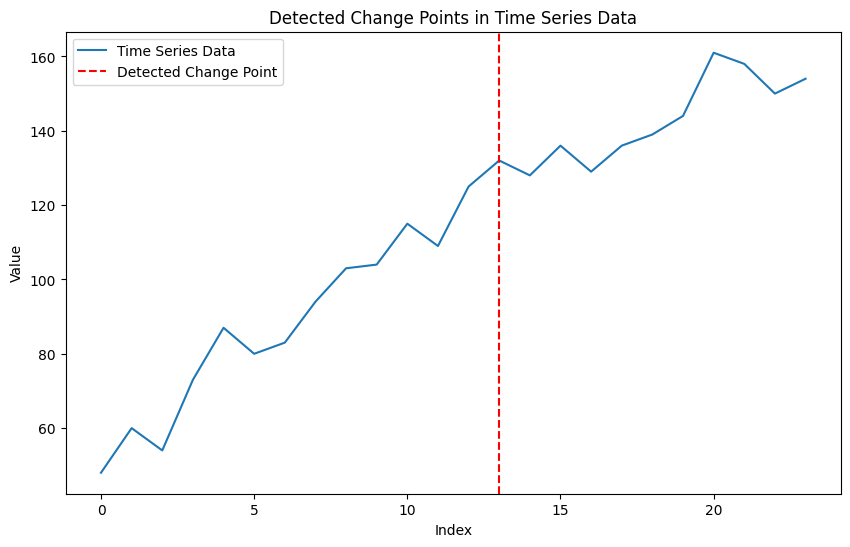

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def buishand_range_test(x):
    """
    Buishand Range Test for change-point detection in time series data.

    Parameters:
    x (list or np.array): The time series data.

    Returns:
    change_point_index (int): The index of the detected change point.
    test_statistic (np.array): The test statistic for each index.
    """
    n = len(x)
    if n < 2:
        raise ValueError("Time series data must contain at least two observations.")

    # Compute cumulative sum of the time series
    S = np.cumsum(x - np.mean(x))
    S = np.insert(S, 0, 0)  # Add zero at the beginning for ease of computation

    # Compute range statistics
    R = np.max(S) - np.min(S)

    # Calculate the test statistic for each possible change point
    test_statistic = np.zeros(n)
    for k in range(1, n):
        S1 = S[k]
        S2 = S[-1] - S[k]
        test_statistic[k] = np.abs(S1 - S2)

    # Find the index of the maximum test statistic
    change_point_index = np.argmax(test_statistic) + 1  # Adding 1 due to index offset

    return change_point_index, test_statistic

def detect_change_points(data, min_segment_length=10, max_change_points=np.inf):
    """
    Detect multiple change points in a time series data.

    Parameters:
    data (np.array): The time series data.
    min_segment_length (int): Minimum length of the segment to be considered for change point detection.
    max_change_points (int): Maximum number of change points to detect.

    Returns:
    change_points (list): List of detected change points.
    """
    change_points = []
    segment_start = 0
    segment_end = len(data)

    while segment_end - segment_start > min_segment_length and len(change_points) < max_change_points:
        segment = data[segment_start:segment_end]
        change_point, test_statistic = buishand_range_test(segment)

        if test_statistic.max() > np.percentile(test_statistic, 95):  # Thresholding based on percentile
            change_point_index = segment_start + change_point
            change_points.append(change_point_index)

            # Update the segment range
            if len(change_points) < max_change_points:
                if change_point_index - segment_start > min_segment_length:
                    segment_end = change_point_index
                if len(data) - change_point_index > min_segment_length:
                    segment_start = change_point_index
                else:
                    break
            else:
                break
        else:
            break

    return change_points

# Example usage

# Generate example data with multiple change points
# np.random.seed(0)
# dataa = np.concatenate([
#     np.random.normal(0, 1, 50),
#     np.random.normal(5, 1, 50),
#     np.random.normal(0, 1, 50),
#     np.random.normal(-5, 1, 50)
# ])

change_points = detect_change_points(data['Publications'])
print(f"Detected change points at indices: {change_points}")

# Plot the data with detected change points
plt.figure(figsize=(10, 6))
plt.plot(data['Publications'], label='Time Series Data')
for cp in change_points:
    plt.axvline(x=cp, color='r', linestyle='--', label='Detected Change Point' if cp == change_points[0] else "")
plt.title('Detected Change Points in Time Series Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()


In [46]:
change_points[0]

13

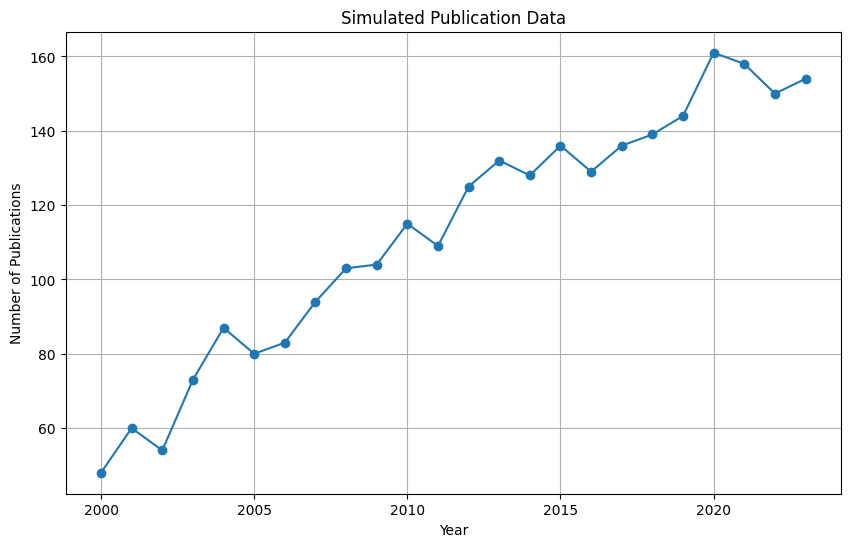

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Mean Squared Error on Test Data: 136.10860929815098
Mean Absolute Percentage Error on Test Data: 0.05572548730875896


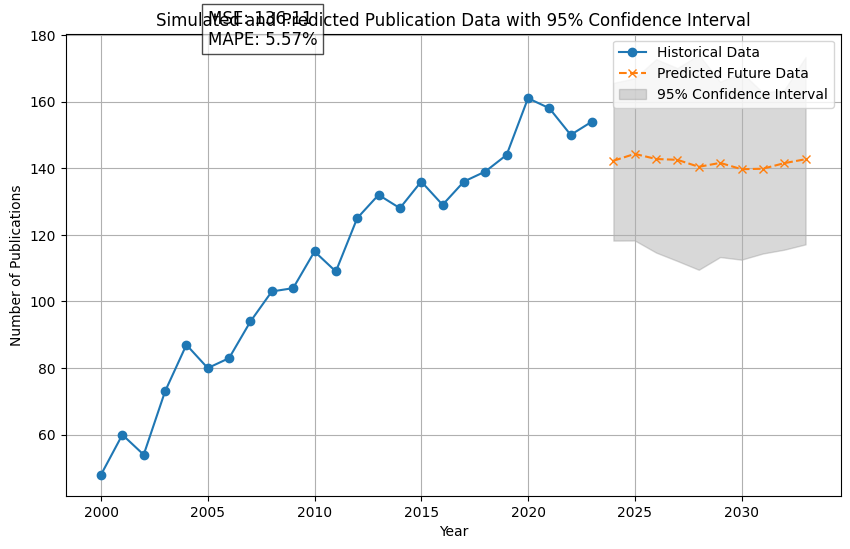

Predicted publications for 2024: 142.22 (95% CI: [118.27, 165.62])
Predicted publications for 2025: 144.30 (95% CI: [118.30, 166.98])
Predicted publications for 2026: 142.76 (95% CI: [114.67, 172.72])
Predicted publications for 2027: 142.51 (95% CI: [112.14, 170.04])
Predicted publications for 2028: 140.41 (95% CI: [109.51, 174.06])
Predicted publications for 2029: 141.59 (95% CI: [113.33, 165.92])
Predicted publications for 2030: 139.70 (95% CI: [112.54, 168.82])
Predicted publications for 2031: 139.84 (95% CI: [114.39, 162.67])
Predicted publications for 2032: 141.51 (95% CI: [115.54, 163.46])
Predicted publications for 2033: 142.69 (95% CI: [117.13, 173.34])


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Generate example time series data: Let's simulate yearly publication data
np.random.seed(42)
years = np.arange(2000, 2024)
publications = np.random.poisson(lam=50, size=len(years)) + np.cumsum(np.random.randint(0, 10, size=len(years)))

# Creating a DataFrame for visualization
data = pd.DataFrame({'Year': years, 'Publications': publications})

# Plotting the example data
plt.figure(figsize=(10, 6))
plt.plot(data['Year'], data['Publications'], marker='o')
plt.title('Simulated Publication Data')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.grid(True)
plt.show()

# Preparing the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Publications']])

# Creating sequences (we will use the past 3 years to predict the next year)
def create_sequences(data, time_steps=3):
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:i+time_steps, 0])
        y.append(data[i+time_steps, 0])
    return np.array(x), np.array(y)

time_steps = 3
X, y = create_sequences(scaled_data, time_steps)

# Train-test split (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model (suppress verbose output)
model.fit(X_train, y_train, epochs=100, verbose=0)

# Predicting on the test set (suppress verbose output)
y_pred_scaled = model.predict(X_test, verbose=0)
y_pred = scaler.inverse_transform(y_pred_scaled)

# Evaluate the model using Mean Squared Error (MSE) and Mean Absolute Percentage Error (MAPE)
mse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred)
mape = mean_absolute_percentage_error(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred)
print(f'Mean Squared Error on Test Data: {mse}')
print(f'Mean Absolute Percentage Error on Test Data: {mape}')

# Predict the next 10 years of publications with confidence intervals
future_predictions = []
conf_intervals = []
num_simulations = 100  # Number of simulations to estimate confidence intervals

for i in range(10):
    simulated_preds = []
    last_sequence = scaled_data[-time_steps:]

    # Simulate predictions by adding some noise to each prediction
    for _ in range(num_simulations):
        # Reshape last_sequence for prediction
        last_sequence = last_sequence.reshape((1, time_steps, 1))

        # Predict the next value (suppress verbose output)
        next_pred_scaled = model.predict(last_sequence, verbose=0)
        next_pred = scaler.inverse_transform(next_pred_scaled)

        # Adding small noise for simulation
        simulated_preds.append(next_pred[0][0] + np.random.normal(0, 0.1 * next_pred[0][0]))

        # Update the last_sequence with the new predicted value
        last_sequence = np.append(last_sequence[0][1:], next_pred_scaled).reshape((time_steps, 1))

    # Calculate mean and confidence interval (95%)
    mean_pred = np.mean(simulated_preds)
    lower_bound = np.percentile(simulated_preds, 2.5)
    upper_bound = np.percentile(simulated_preds, 97.5)

    future_predictions.append(mean_pred)
    conf_intervals.append((lower_bound, upper_bound))

# Plot the future predictions with confidence intervals and display MSE and MAPE in the plot
future_years = np.arange(2024, 2024+10)
plt.figure(figsize=(10, 6))
plt.plot(data['Year'], data['Publications'], marker='o', label='Historical Data')
plt.plot(future_years, future_predictions, marker='x', linestyle='--', label='Predicted Future Data')

# Adding the confidence intervals
lower_bounds = [ci[0] for ci in conf_intervals]
upper_bounds = [ci[1] for ci in conf_intervals]
plt.fill_between(future_years, lower_bounds, upper_bounds, color='gray', alpha=0.3, label='95% Confidence Interval')

# Annotate the plot with MSE and MAPE
plt.text(2005, max(publications) * 1.1, f'MSE: {mse:.2f}\nMAPE: {mape:.2%}', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

plt.title('Simulated and Predicted Publication Data with 95% Confidence Interval')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.legend()
plt.grid(True)
plt.show()

# Print future predictions with confidence intervals
for year, prediction, ci in zip(future_years, future_predictions, conf_intervals):
    print(f"Predicted publications for {year}: {prediction:.2f} (95% CI: [{ci[0]:.2f}, {ci[1]:.2f}])")


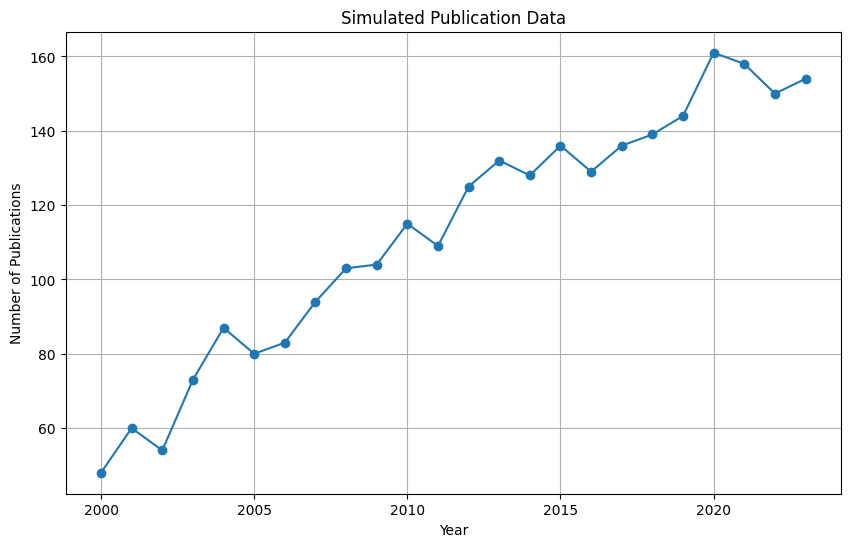

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Mean Squared Error on Test Data: 143.20830476512202
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/s

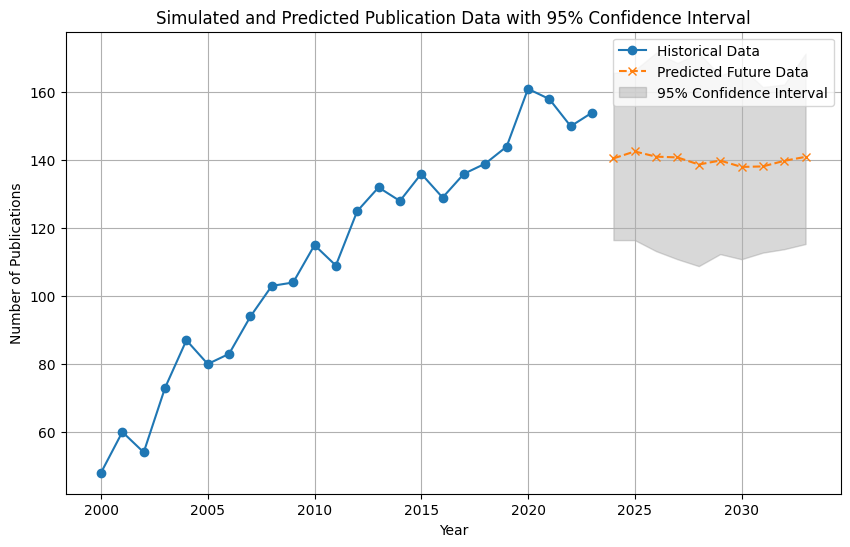

Predicted publications for 2024: 140.52 (95% CI: [116.47, 165.66])
Predicted publications for 2025: 142.57 (95% CI: [116.47, 166.49])
Predicted publications for 2026: 141.04 (95% CI: [113.23, 171.64])
Predicted publications for 2027: 140.82 (95% CI: [110.85, 168.62])
Predicted publications for 2028: 138.73 (95% CI: [108.82, 171.57])
Predicted publications for 2029: 139.90 (95% CI: [112.35, 164.90])
Predicted publications for 2030: 138.02 (95% CI: [110.85, 167.29])
Predicted publications for 2031: 138.17 (95% CI: [112.79, 161.54])
Predicted publications for 2032: 139.82 (95% CI: [113.80, 162.25])
Predicted publications for 2033: 140.98 (95% CI: [115.32, 171.37])


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Generate example time series data: Let's simulate yearly publication data
np.random.seed(42)
years = np.arange(2000, 2024)
publications = np.random.poisson(lam=50, size=len(years)) + np.cumsum(np.random.randint(0, 10, size=len(years)))

# Creating a DataFrame for visualization
data = pd.DataFrame({'Year': years, 'Publications': publications})

# Plotting the example data
plt.figure(figsize=(10, 6))
plt.plot(data['Year'], data['Publications'], marker='o')
plt.title('Simulated Publication Data')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.grid(True)
plt.show()

# Preparing the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Publications']])

# Creating sequences (we will use the past 3 years to predict the next year)
def create_sequences(data, time_steps=3):
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:i+time_steps, 0])
        y.append(data[i+time_steps, 0])
    return np.array(x), np.array(y)

time_steps = 3
X, y = create_sequences(scaled_data, time_steps)

# Train-test split (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=100, verbose=0)

# Predicting on the test set
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred)
print(f'Mean Squared Error on Test Data: {mse}')

# Predict the next 10 years of publications with confidence intervals
future_predictions = []
conf_intervals = []
num_simulations = 100  # Number of simulations to estimate confidence intervals

for i in range(10):
    simulated_preds = []
    last_sequence = scaled_data[-time_steps:]

    # Simulate predictions by adding some noise to each prediction
    for _ in range(num_simulations):
        # Reshape last_sequence for prediction
        last_sequence = last_sequence.reshape((1, time_steps, 1))

        # Predict the next value
        next_pred_scaled = model.predict(last_sequence)
        next_pred = scaler.inverse_transform(next_pred_scaled)

        # Adding small noise for simulation
        simulated_preds.append(next_pred[0][0] + np.random.normal(0, 0.1 * next_pred[0][0]))

        # Update the last_sequence with the new predicted value
        last_sequence = np.append(last_sequence[0][1:], next_pred_scaled).reshape((time_steps, 1))

    # Calculate mean and confidence interval (95%)
    mean_pred = np.mean(simulated_preds)
    lower_bound = np.percentile(simulated_preds, 2.5)
    upper_bound = np.percentile(simulated_preds, 97.5)

    future_predictions.append(mean_pred)
    conf_intervals.append((lower_bound, upper_bound))

# Plot the future predictions with confidence intervals
future_years = np.arange(2024, 2024+10)
plt.figure(figsize=(10, 6))
plt.plot(data['Year'], data['Publications'], marker='o', label='Historical Data')
plt.plot(future_years, future_predictions, marker='x', linestyle='--', label='Predicted Future Data')

# Adding the confidence intervals
lower_bounds = [ci[0] for ci in conf_intervals]
upper_bounds = [ci[1] for ci in conf_intervals]
plt.fill_between(future_years, lower_bounds, upper_bounds, color='gray', alpha=0.3, label='95% Confidence Interval')

plt.title('Simulated and Predicted Publication Data with 95% Confidence Interval')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.legend()
plt.grid(True)
plt.show()

# Print future predictions with confidence intervals
for year, prediction, ci in zip(future_years, future_predictions, conf_intervals):
    print(f"Predicted publications for {year}: {prediction:.2f} (95% CI: [{ci[0]:.2f}, {ci[1]:.2f}])")


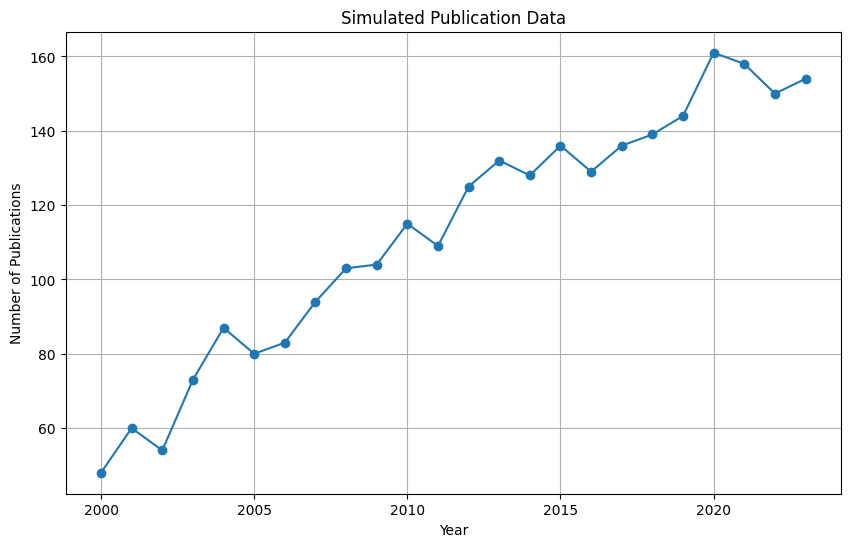

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Mean Squared Error on Test Data: 164.20574176749216
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


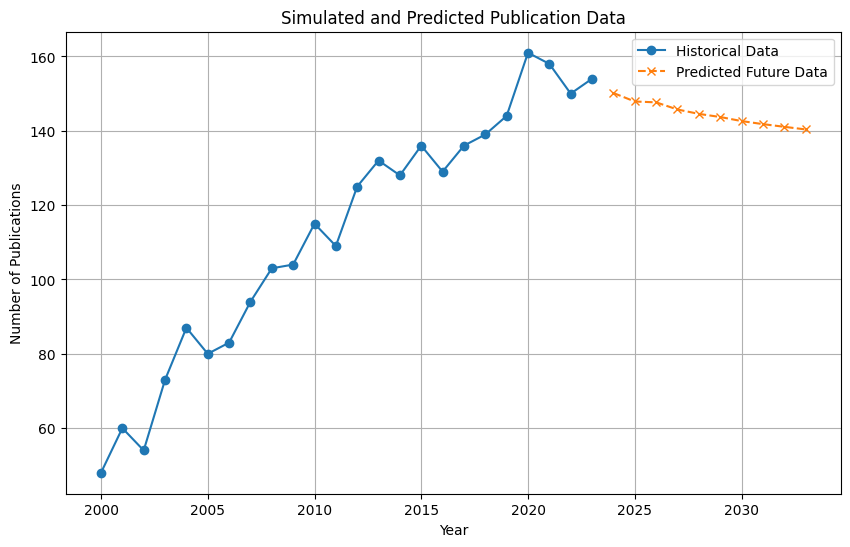

Predicted publications for 2024: 150.16
Predicted publications for 2025: 147.88
Predicted publications for 2026: 147.65
Predicted publications for 2027: 145.73
Predicted publications for 2028: 144.55
Predicted publications for 2029: 143.71
Predicted publications for 2030: 142.61
Predicted publications for 2031: 141.79
Predicted publications for 2032: 141.07
Predicted publications for 2033: 140.36


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Generate example time series data: Let's simulate yearly publication data
np.random.seed(42)
years = np.arange(2000, 2024)
publications = np.random.poisson(lam=50, size=len(years)) + np.cumsum(np.random.randint(0, 10, size=len(years)))

# Creating a DataFrame for visualization
data = pd.DataFrame({'Year': years, 'Publications': publications})

# Plotting the example data
plt.figure(figsize=(10, 6))
plt.plot(data['Year'], data['Publications'], marker='o')
plt.title('Simulated Publication Data')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.grid(True)
plt.show()

# Preparing the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Publications']])

# Creating sequences (we will use the past 3 years to predict the next year)
def create_sequences(data, time_steps=3):
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:i+time_steps, 0])
        y.append(data[i+time_steps, 0])
    return np.array(x), np.array(y)

time_steps = 3
X, y = create_sequences(scaled_data, time_steps)

# Train-test split (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=100, verbose=0)

# Predicting on the test set
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred)
print(f'Mean Squared Error on Test Data: {mse}')

# Predict the next 10 years of publications
future_predictions = []
last_sequence = scaled_data[-time_steps:]

for i in range(10):
    # Reshape last_sequence for prediction
    last_sequence = last_sequence.reshape((1, time_steps, 1))

    # Predict the next value
    next_pred_scaled = model.predict(last_sequence)
    next_pred = scaler.inverse_transform(next_pred_scaled)

    # Store the predicted value
    future_predictions.append(next_pred[0][0])

    # Update the last_sequence with the new predicted value
    last_sequence = np.append(last_sequence[0][1:], next_pred_scaled).reshape((time_steps, 1))

# Plot the future predictions
future_years = np.arange(2024, 2024+10)
plt.figure(figsize=(10, 6))
plt.plot(data['Year'], data['Publications'], marker='o', label='Historical Data')
plt.plot(future_years, future_predictions, marker='x', linestyle='--', label='Predicted Future Data')
plt.title('Simulated and Predicted Publication Data')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.legend()
plt.grid(True)
plt.show()

# Print future predictions
for year, prediction in zip(future_years, future_predictions):
    print(f"Predicted publications for {year}: {prediction:.2f}")


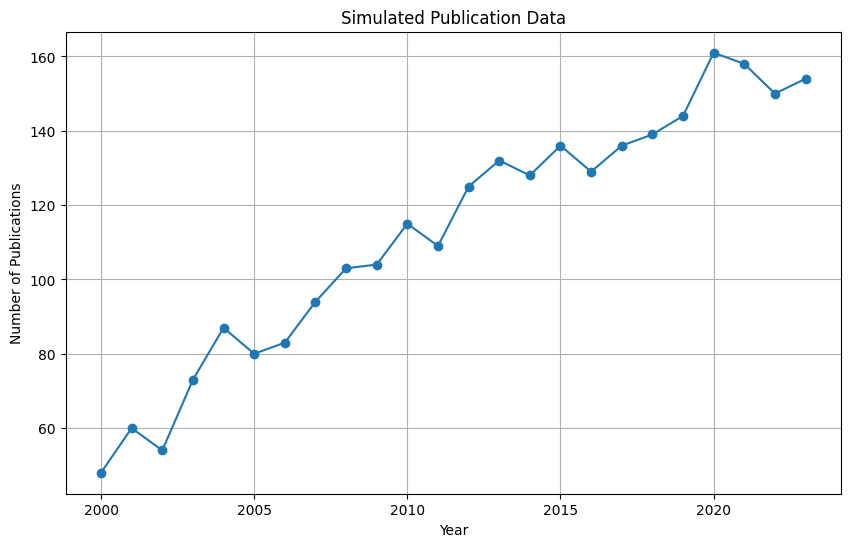

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
Predicted publications for 2024: 151.61137


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Generate example time series data: Let's simulate yearly publication data
np.random.seed(42)
years = np.arange(2000, 2024)
publications = np.random.poisson(lam=50, size=len(years)) + np.cumsum(np.random.randint(0, 10, size=len(years)))

# Creating a DataFrame for visualization
data = pd.DataFrame({'Year': years, 'Publications': publications})

# Plotting the example data
plt.figure(figsize=(10, 6))
plt.plot(data['Year'], data['Publications'], marker='o')
plt.title('Simulated Publication Data')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.grid(True)
plt.show()

# Preparing the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Publications']])

# Creating sequences (we will use the past 3 years to predict the next year)
def create_sequences(data, time_steps=3):
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:i+time_steps, 0])
        y.append(data[i+time_steps, 0])
    return np.array(x), np.array(y)

time_steps = 3
X, y = create_sequences(scaled_data, time_steps)

# Reshape the input to be [samples, time steps, features] for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X, y, epochs=100, verbose=0)

# Making predictions for the next year (2024)
last_sequence = scaled_data[-time_steps:]
last_sequence = last_sequence.reshape((1, time_steps, 1))
predicted_value_scaled = model.predict(last_sequence)

# Inverse scaling to get the actual predicted number of publications
predicted_value = scaler.inverse_transform(predicted_value_scaled)

print("Predicted publications for 2024:", predicted_value[0][0])
